In [1]:
# Cell 1: Install Libraries
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 53.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147776 sha256=dffef9fbb1ccf433d36f8f9235cf0350ff8b87f729864618755d5fdd3ef062b4
  Stored in directory: /root/.cache/pip/wheels/7a/79/8e/0d6e404db9f1e82af2e40b49161d6acab485d75dfb0470ac08
Successfully built chess


In [2]:
# Cell 2: Imports
# VERSION 5: Added Dropout, Early Stopping, Default Augmentation, Improved Graphs.

# %% [markdown]
# # Advanced Chess AI V5 (Supervised Learning with Regularization & Early Stopping)
#
# Building on V4, let's make the AI even smarter by tackling overfitting!
#
# **New in V5:**
# *   **Dropout Regularization:** Added Dropout layers to the model architecture to improve generalization (Cell 6).
# *   **Early Stopping:** Training now stops automatically if validation loss doesn't improve for a set number of epochs (Cell 10).
# *   **Data Augmentation Default:** Data augmentation (flipping) is now enabled by default during data processing (Cell 7). **Remember to reprocess data if loading V4 data!**
# *   **Weight Decay Adjustment:** Slightly increased default weight decay (Cell 9).
# *   **Training Accuracy Plot:** Added training accuracy to the performance graph for comparison (Cell 11).
# *   **Clearer Configuration:** Key hyperparameters like Dropout Rate and Early Stopping Patience are easily configurable.
#
# Ready to train a more robust and potentially better-generalizing AI? Let's go! ❤️

# %% {"cell_type": "code"}
import os
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F # Often useful for activation functions etc.
from chess import Board, pgn, Move, flip_horizontal # Board has SVG capabilities!
from tqdm.notebook import tqdm # Use notebook version for better display
import pickle
import gc # Garbage collector interface
import matplotlib.pyplot as plt # For plotting graphs
import random
from sklearn.model_selection import train_test_split # For easy data splitting!
from IPython.display import display, SVG # To display SVG output

print("Imports successful!")

Imports successful!


In [3]:
# Cell 4: Auxiliary Functions (Board Rep, Data Gen, Move Encoding)
# Contains helpers for board representation, data generation, move encoding, ELO parsing.
# Data augmentation logic is included within process_games_generator_v4.

# %% {"cell_type": "code"}
def board_to_matrix_v4(board: Board, flip: bool = False):
    """
    Converts a board state into a matrix representation (multi-channel).
    Version 4: Includes piece positions, turn, castling rights, and optional horizontal flip.
    Input features are consistent with V3.

    Output shape: (18, 8, 8) - float32 numpy array
    Channels:
    - 0-5: White pieces (P, N, B, R, Q, K)
    - 6-11: Black pieces (P, N, B, R, Q, K)
    - 12: White King Castling Right (1 if True)
    - 13: White Queen Castling Right (1 if True)
    - 14: Black King Castling Right (1 if True)
    - 15: Black Queen Castling Right (1 if True)
    - 16: White's Turn (1 if White's turn)
    - 17: Constant plane of 1s
    """
    matrix = np.zeros((18, 8, 8), dtype=np.float32)
    current_board = board.copy() # Work on a copy to avoid modifying the original board

    # Apply flip transformation if requested
    if flip:
        current_board = current_board.transform(flip_horizontal)

    # Populate piece layers based on the (potentially flipped) board state
    piece_map = current_board.piece_map()
    for square, piece in piece_map.items():
        row, col = divmod(square, 8)
        piece_idx = piece.piece_type - 1
        color_offset = 0 if piece.color else 6 # White=0, Black=6
        matrix[piece_idx + color_offset, row, col] = 1

    # Populate castling rights layers (use ORIGINAL board's perspective)
    if board.has_kingside_castling_rights(True): matrix[12, :, :] = 1
    if board.has_queenside_castling_rights(True): matrix[13, :, :] = 1
    if board.has_kingside_castling_rights(False): matrix[14, :, :] = 1
    if board.has_queenside_castling_rights(False): matrix[15, :, :] = 1

    # Populate turn layer (based on the CURRENT board state after potential flip)
    if current_board.turn: # True if White's turn in the current_board state
        matrix[16, :, :] = 1

    # Populate constant plane
    matrix[17, :, :] = 1

    return matrix

def get_value_target(game_result: str) -> float:
    """ Assigns a numerical value based on the game result from White's perspective. """
    if game_result == '1-0': return 1.0
    if game_result == '0-1': return -1.0
    if game_result == '1/2-1/2': return 0.0
    return 0.0 # Default for '*' or unexpected results

def parse_elo(elo_str: str) -> int:
    """ Safely parses ELO string, returns 0 if invalid. """
    try:
        return int(str(elo_str).replace('?', '').strip()) # Add str() for robustness
    except (ValueError, AttributeError, TypeError):
        return 0

def flip_move(move: Move) -> Move:
    """ Flips a move horizontally. """
    from_sq_row, from_sq_col = divmod(move.from_square, 8)
    to_sq_row, to_sq_col = divmod(move.to_square, 8)

    from_square_flipped = from_sq_row * 8 + (7 - from_sq_col)
    to_square_flipped = to_sq_row * 8 + (7 - to_sq_col)

    promotion_flipped = move.promotion
    return Move(from_square_flipped, to_square_flipped, promotion=promotion_flipped)

def process_games_generator_v4(pgn_filepath, min_elo=0, max_games_in_file=None, limit_total_samples=None, augment=True):
    """
    Generator that processes a SINGLE PGN file iteratively with filters.
    Yields tuples of (board_matrix, move_uci, value_target, avg_elo) for each position.
    Handles augmentation internally if enabled.
    """
    print(f"\nStarting V4 Generator for file: {os.path.basename(pgn_filepath)}")
    print(f"  Settings: min_elo={min_elo}, max_games={max_games_in_file}, limit_samples={limit_total_samples}, augment={augment}")
    total_samples_yielded = 0
    processed_games_count = 0
    accepted_games_count = 0
    elo_list_accepted = []

    try:
        with open(pgn_filepath, 'r', encoding='utf-8', errors='ignore') as pgn_file:
            while True:
                # Check total sample limit
                if limit_total_samples is not None and total_samples_yielded >= limit_total_samples:
                    print(f"\nGenerator hit total sample limit ({limit_total_samples}). Stopping.")
                    return elo_list_accepted # Return collected ELOs

                # Check game limit for this file
                if max_games_in_file is not None and processed_games_count >= max_games_in_file:
                    print(f"Generator hit game limit ({max_games_in_file}) for this file. Stopping.")
                    break # Stop processing this file

                game_headers = None
                current_game_start_pos = pgn_file.tell() # Remember position before reading game

                try:
                    game_headers = pgn.read_headers(pgn_file)
                    if game_headers is None: break # Normal end of file
                    processed_games_count += 1

                    white_elo = parse_elo(game_headers.get("WhiteElo", "0"))
                    black_elo = parse_elo(game_headers.get("BlackElo", "0"))
                    avg_elo = (white_elo + black_elo) / 2 if white_elo > 0 and black_elo > 0 else 0

                    if white_elo < min_elo and black_elo < min_elo:
                        try: pgn.read_game(pgn_file) # Read and discard to advance pointer
                        except Exception: pass
                        continue

                    pgn_file.seek(current_game_start_pos)
                    game = pgn.read_game(pgn_file)
                    if game is None:
                         print(f"Warning: Could not read game body after headers for game {processed_games_count}. Skipping.")
                         continue

                except EOFError: break
                except Exception as e:
                    print(f"Skipping game {processed_games_count} due to header/initial parsing error: {e}")
                    try: # Recovery attempt
                        while True:
                            line = pgn_file.readline()
                            if not line: break
                            if line.startswith('[Event '):
                                pgn_file.seek(pgn_file.tell() - len(line.encode('utf-8')))
                                break
                    except Exception as re:
                         print(f"Recovery attempt failed: {re}. Stopping.")
                         break
                    continue

                accepted_games_count += 1
                if avg_elo > 0: elo_list_accepted.append(avg_elo)

                result = game.headers.get("Result", "*")
                value_target = get_value_target(result)
                board = game.board()

                try:
                    move_count_in_game = 0
                    for move in game.mainline_moves():
                        move_count_in_game += 1
                        if limit_total_samples is not None and total_samples_yielded >= limit_total_samples:
                             print(f"\nGenerator hit total sample limit ({limit_total_samples}) mid-game. Stopping.")
                             return elo_list_accepted

                        # Original Sample
                        matrix = board_to_matrix_v4(board, flip=False)
                        move_uci = move.uci()
                        yield matrix, move_uci, value_target, avg_elo
                        total_samples_yielded += 1

                        # Augmented (Flipped) Sample
                        if augment:
                            if limit_total_samples is not None and total_samples_yielded >= limit_total_samples:
                                 print(f"\nGenerator hit total sample limit ({limit_total_samples}) before augment. Stopping.")
                                 return elo_list_accepted

                            matrix_flipped = board_to_matrix_v4(board, flip=True)
                            move_flipped = flip_move(move)
                            move_uci_flipped = move_flipped.uci()
                            yield matrix_flipped, move_uci_flipped, value_target, avg_elo
                            total_samples_yielded += 1

                        board.push(move)

                except (ValueError, AssertionError, AttributeError) as e:
                    print(f"Warning: Skipping moves in game {accepted_games_count} due to error: {e}. Game had {move_count_in_game} moves.")
                    break # Stop processing this game's moves

    except FileNotFoundError: print(f"Error: PGN file not found at {pgn_filepath}")
    except Exception as e: print(f"An unexpected error occurred while processing {os.path.basename(pgn_filepath)}: {e}")

    print(f"\nFinished generator for file {os.path.basename(pgn_filepath)}.")
    print(f"  Games Scanned: {processed_games_count}, Accepted: {accepted_games_count}")
    return elo_list_accepted

def encode_moves_v4(moves_uci_list):
    """ Encodes a list of UCI move strings into integer labels. Returns all mappings. """
    print(f"\nEncoding {len(moves_uci_list)} policy targets...")
    unique_moves = sorted(list(set(moves_uci_list))) # Sort for consistent mapping
    move_to_int = {move: idx for idx, move in enumerate(unique_moves)}
    int_to_move = {idx: move for move, idx in move_to_int.items()} # Inverse mapping
    num_classes = len(unique_moves)
    encoded_y = np.array([move_to_int[move] for move in moves_uci_list], dtype=np.int64) # Use int64 for PyTorch CrossEntropyLoss
    print(f"Found {num_classes} unique moves across all samples.")
    return encoded_y, move_to_int, int_to_move, num_classes

print("Auxiliary functions defined.")

Auxiliary functions defined.


In [4]:
# Cell 5: Dataset Class (V5)

# %% {"cell_type": "code"}
class ChessDatasetV5(Dataset):
    """ Basic PyTorch Dataset for Chess Data """
    def __init__(self, X_matrices, y_policy_encoded, y_value_targets, dataset_name=""):
        self.X = X_matrices
        self.y_policy = y_policy_encoded
        self.y_value = y_value_targets
        self.name = dataset_name
        print(f"\nChessDatasetV5 ({self.name}) initialized:")
        if len(self.X) > 0:
            print(f"  Number of samples: {len(self.X)}")
            print(f"  Sample X type: {type(self.X[0])}, shape: {self.X[0].shape if isinstance(self.X[0], np.ndarray) else 'N/A'}")
            print(f"  Sample y_policy type: {type(self.y_policy[0])}, value: {self.y_policy[0] if len(self.y_policy) > 0 else 'N/A'}")
            print(f"  Sample y_value type: {type(self.y_value[0])}, value: {self.y_value[0] if len(self.y_value) > 0 else 'N/A'}")
        else:
            print(f"  Dataset ({self.name}) is empty.")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Returns data as tensors for the DataLoader
        return (torch.tensor(self.X[idx], dtype=torch.float32),
                torch.tensor(self.y_policy[idx], dtype=torch.long), # Policy target must be torch.long
                torch.tensor(self.y_value[idx], dtype=torch.float32))

print("ChessDatasetV5 class defined.")

ChessDatasetV5 class defined.


In [5]:
# Cell 6: Model Definition (V5 - ResNet with Dropout)

# %% {"cell_type": "code"}
class ResidualBlock(nn.Module):
    """ Standard Residual Block with Conv -> BN -> ReLU -> Conv -> BN -> Add -> ReLU """
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out

class ChessModelV5(nn.Module):
    """
    V5: Dual-headed ResNet-style model with Dropout for regularization.
    Takes (N, 18, 8, 8) input tensor.
    Outputs policy logits (N, num_moves) and value prediction (N, 1).
    """
    def __init__(self, num_policy_classes, num_res_blocks=9, num_channels=128, dropout_rate=0.3): ### V5 Change: Added dropout_rate
        super(ChessModelV5, self).__init__()
        input_channels = 18 # From board_to_matrix_v4
        self.dropout_rate = dropout_rate ### V5 Change: Store dropout rate

        # --- Input Convolution Block ---
        self.conv_in = nn.Sequential(
            nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(inplace=True)
        )

        # --- Residual Blocks Tower ---
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_channels) for _ in range(num_res_blocks)]
        )

        # --- Policy Head ---
        self.policy_conv = nn.Conv2d(num_channels, 32, kernel_size=1, bias=False)
        self.policy_bn = nn.BatchNorm2d(32)
        self.policy_relu = nn.ReLU(inplace=True)
        self.policy_flatten = nn.Flatten()
        policy_flat_size = self._get_flat_size(lambda x: self.policy_relu(self.policy_bn(self.policy_conv(x))), input_channels, num_channels)
        ### V5 Change: Added Dropout before final policy layer
        self.policy_dropout = nn.Dropout(p=self.dropout_rate)
        self.policy_fc = nn.Linear(policy_flat_size, num_policy_classes)

        # --- Value Head ---
        self.value_conv = nn.Conv2d(num_channels, 16, kernel_size=1, bias=False)
        self.value_bn = nn.BatchNorm2d(16)
        self.value_relu = nn.ReLU(inplace=True)
        self.value_flatten = nn.Flatten()
        value_flat_size = self._get_flat_size(lambda x: self.value_relu(self.value_bn(self.value_conv(x))), input_channels, num_channels)
        self.value_fc1 = nn.Linear(value_flat_size, 64)
        self.value_relu2 = nn.ReLU(inplace=True)
        ### V5 Change: Added Dropout layers in value head
        self.value_dropout1 = nn.Dropout(p=self.dropout_rate)
        self.value_fc2 = nn.Linear(64, 1)
        self.value_tanh = nn.Tanh() # Squash output to [-1, 1]

        print(f"\nChessModelV5 initialized:")
        print(f"  Input Channels: {input_channels}")
        print(f"  Residual Blocks: {num_res_blocks} x {num_channels} channels")
        print(f"  Dropout Rate: {self.dropout_rate}") ### V5 Change: Print dropout rate
        print(f"  Policy Head Flattened Size: {policy_flat_size}")
        print(f"  Value Head Flattened Size: {value_flat_size}")
        print(f"  Output Policy Classes: {num_policy_classes}")

        self._initialize_weights()

    def _get_flat_size(self, head_conv_lambda, input_channels, num_body_channels):
        """ Helper function to calculate flattened size after conv blocks. """
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, 8, 8)
            dummy_body_features = self.conv_in(dummy_input)
            dummy_res_features = self.res_blocks(dummy_body_features)
            dummy_head_features = head_conv_lambda(dummy_res_features)
            flat_size = dummy_head_features.view(1, -1).size(1)
        return flat_size

    def _initialize_weights(self):
        """ Initializes weights using common practices (Kaiming for Conv, Xavier for Linear). """
        print("Initializing model weights...")
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                 nn.init.xavier_uniform_(m.weight)
                 if m.bias is not None:
                     nn.init.constant_(m.bias, 0)
        print("Weight initialization complete.")

    def forward(self, x):
        features = self.conv_in(x)
        features = self.res_blocks(features)

        # Policy Head Forward
        policy = self.policy_conv(features)
        policy = self.policy_bn(policy)
        policy = self.policy_relu(policy)
        policy = self.policy_flatten(policy)
        policy = self.policy_dropout(policy) ### V5 Change: Apply dropout
        policy_logits = self.policy_fc(policy)

        # Value Head Forward
        value = self.value_conv(features)
        value = self.value_bn(value)
        value = self.value_relu(value)
        value = self.value_flatten(value)
        value = self.value_fc1(value)
        value = self.value_relu2(value)
        value = self.value_dropout1(value) ### V5 Change: Apply dropout
        value = self.value_fc2(value)
        value_output = self.value_tanh(value)

        return policy_logits, value_output

print("ChessModelV5 (ResNet style with Dropout) class defined.")

ChessModelV5 (ResNet style with Dropout) class defined.


In [6]:
# Cell 7: Data Loading, Processing, and Splitting (V5)

# %% {"cell_type": "code"}
# --- Configuration ---
LOAD_PREPROCESSED_DATA = True  # <<< SET TO False for the first run, True for subsequent runs
PREPROCESSED_DATA_DIR = "/kaggle/input/aguemntation-files/processed_data/" # Directory containing saved data (if LOAD_PREPROCESSED_DATA=True)
#PREPROCESSED_DATA_DIR = "/kaggle/working/processed_data/" # <<< USE THIS if generating data for the first time
PREPROCESSED_NPZ_PATH = os.path.join(PREPROCESSED_DATA_DIR, "chess_data_split.npz")
PREPROCESSED_MAPPINGS_PATH = os.path.join(PREPROCESSED_DATA_DIR, "chess_mappings_processed.pkl")

# PGN Source (Only used if LOAD_PREPROCESSED_DATA = False)
PGN_FILE_PATH = None
PGN_DIR = "/kaggle/input/lichess-high-quality-games/Lichess Elite Database" # Example path

# Output paths for trained model and mappings
MODEL_SAVE_PATH = "/kaggle/working/chess_model_v5_resnet_dropout.pth" ### V5 Change: Path name
MAPPING_SAVE_PATH = "/kaggle/working/chess_mappings_v5.pkl" ### V5 Change: Path name

# --- Data Filtering & Sampling (Only used if LOAD_PREPROCESSED_DATA = False) ---
MIN_ELO = 2400
MAX_GAMES_PER_FILE = 1000 # Limit games read *per file* if processing a directory
TOTAL_SAMPLE_LIMIT = 3_000_000 # Max board positions (samples) to load *before* splitting

### V5 Change: Augmentation is highly recommended to reduce overfitting. Defaulting to True.
### ** IMPORTANT: If LOAD_PREPROCESSED_DATA=True, ensure the loaded data was created with the desired augmentation setting! **
### ** If you change USE_AUGMENTATION, you MUST set LOAD_PREPROCESSED_DATA = False and re-process.**
USE_AUGMENTATION = True # <<< Set to True unless you have a specific reason not to

VALIDATION_SET_SIZE = 0.15 # Use 15% of the loaded data for validation

# --- Initialize variables ---
data_ready = False
X_train_np, y_policy_train_np, y_value_train_np = None, None, None
X_val_np, y_policy_val_np, y_value_val_np = None, None, None
move_to_int, int_to_move, num_classes = None, None, None
elo_all_list = []

# --- Create directory if it doesn't exist (Needed if saving preprocessed data) ---
if not LOAD_PREPROCESSED_DATA:
     os.makedirs(PREPROCESSED_DATA_DIR, exist_ok=True)

# --- Attempt to Load Preprocessed Data ---
if LOAD_PREPROCESSED_DATA and os.path.exists(PREPROCESSED_NPZ_PATH) and os.path.exists(PREPROCESSED_MAPPINGS_PATH):
    print(f"--- Loading Preprocessed Data ---")
    print(f"  Source Directory: {PREPROCESSED_DATA_DIR}")
    print(f"  *** Ensure this data was created with USE_AUGMENTATION={USE_AUGMENTATION} ***") # V5 Warning
    try:
        print(f"  Loading arrays from: {PREPROCESSED_NPZ_PATH}")
        with np.load(PREPROCESSED_NPZ_PATH) as data:
            X_train_np = data['X_train']
            y_policy_train_np = data['y_policy_train']
            y_value_train_np = data['y_value_train']
            X_val_np = data['X_val']
            y_policy_val_np = data['y_policy_val']
            y_value_val_np = data['y_value_val']
        print("    NumPy arrays loaded successfully.")

        print(f"  Loading mappings from: {PREPROCESSED_MAPPINGS_PATH}")
        with open(PREPROCESSED_MAPPINGS_PATH, "rb") as f:
            loaded_mappings = pickle.load(f)
        move_to_int = loaded_mappings['move_to_int']
        int_to_move = loaded_mappings['int_to_move']
        num_classes = loaded_mappings['num_classes']
        print("    Mappings loaded successfully.")
        print(f"    Train samples: {len(X_train_np)}, Val samples: {len(X_val_np)}, Num Classes: {num_classes}")

        data_ready = True # Flag that data is ready

    except Exception as e:
        print(f"  Error loading preprocessed data: {e}. Will reprocess from PGNs.")
        X_train_np, y_policy_train_np, y_value_train_np = None, None, None
        X_val_np, y_policy_val_np, y_value_val_np = None, None, None
        move_to_int, int_to_move, num_classes = None, None, None
        data_ready = False

# --- Reprocess Data from PGNs if Loading Failed or Disabled ---
if not data_ready:
    print("\n--- Processing Data from PGN Files ---")
    print(f"  Augmentation Enabled: {USE_AUGMENTATION}")
    print(f"  Preprocessed data will be saved to: {PREPROCESSED_DATA_DIR}")

    pgn_files_to_process = []
    if PGN_FILE_PATH and os.path.isfile(PGN_FILE_PATH):
        pgn_files_to_process = [PGN_FILE_PATH]
        print(f"Processing single PGN file: {PGN_FILE_PATH}")
    elif PGN_DIR and os.path.isdir(PGN_DIR):
        files_in_dir = sorted([os.path.join(PGN_DIR, f) for f in os.listdir(PGN_DIR) if f.endswith(".pgn")])
        pgn_files_to_process = files_in_dir
        print(f"Found {len(pgn_files_to_process)} PGN files in directory: {PGN_DIR}")
    else:
        print(f"Error: No valid PGN file or directory specified. Check PGN_FILE_PATH or PGN_DIR.")

    X_all_list = []
    y_policy_uci_all_list = []
    y_value_all_list = []
    elo_all_list = [] # Reset elo list

    if pgn_files_to_process:
        print(f"\n--- Starting Data Generation Phase ---")
        global_samples_yielded = 0
        generator_needs_break = False
        for pgn_path in pgn_files_to_process:
            if generator_needs_break: break
            remaining_samples = TOTAL_SAMPLE_LIMIT - global_samples_yielded if TOTAL_SAMPLE_LIMIT else None
            data_generator = process_games_generator_v4(
                pgn_path, min_elo=MIN_ELO, max_games_in_file=MAX_GAMES_PER_FILE,
                limit_total_samples=remaining_samples, augment=USE_AUGMENTATION ### V5 Change: Pass augment flag
            )
            try:
                file_samples = 0
                for matrix, move_uci, value, avg_elo in tqdm(data_generator, desc=f"Processing {os.path.basename(pgn_path)}", leave=False):
                     X_all_list.append(matrix)
                     y_policy_uci_all_list.append(move_uci)
                     y_value_all_list.append(value)
                     if avg_elo > 0: elo_all_list.append(avg_elo)
                     global_samples_yielded += 1
                     file_samples += 1
                     if TOTAL_SAMPLE_LIMIT is not None and global_samples_yielded >= TOTAL_SAMPLE_LIMIT:
                          print(f"\nGlobal sample limit {TOTAL_SAMPLE_LIMIT} reached.")
                          generator_needs_break = True
                          break
                print(f"  Finished {os.path.basename(pgn_path)}, added {file_samples} samples.")
            except Exception as e:
                print(f"Error during generation for {os.path.basename(pgn_path)}: {e}")

        print(f"\n--- Data Generation Complete ---")
        print(f"Collected {len(X_all_list)} total samples (incl. augmentation={USE_AUGMENTATION}).")

        if not X_all_list:
            print("Error: No samples collected.")
            can_proceed = False
        else:
            y_policy_encoded_all, move_to_int, int_to_move, num_classes = encode_moves_v4(y_policy_uci_all_list)
            can_proceed = True

        if can_proceed:
            print(f"\nSplitting data (Train: {1-VALIDATION_SET_SIZE:.0%}, Val: {VALIDATION_SET_SIZE:.0%})...")
            indices = list(range(len(X_all_list)))
            train_indices, val_indices = train_test_split(
                indices, test_size=VALIDATION_SET_SIZE, random_state=42, shuffle=True
            )
            print(f"  Train set size: {len(train_indices)}")
            print(f"  Validation set size: {len(val_indices)}")

            print("\nCreating NumPy arrays...")
            # Use list comprehensions for potentially better memory efficiency during creation
            X_train_np = np.array([X_all_list[i] for i in train_indices], dtype=np.float32)
            y_policy_train_np = np.array([y_policy_encoded_all[i] for i in train_indices], dtype=np.int64)
            y_value_train_np = np.array([y_value_all_list[i] for i in train_indices], dtype=np.float32)
            X_val_np = np.array([X_all_list[i] for i in val_indices], dtype=np.float32)
            y_policy_val_np = np.array([y_policy_encoded_all[i] for i in val_indices], dtype=np.int64)
            y_value_val_np = np.array([y_value_all_list[i] for i in val_indices], dtype=np.float32)
            print("  Arrays created.")

            print(f"--- Saving Preprocessed Data ---")
            try:
                print(f"  Saving arrays to: {PREPROCESSED_NPZ_PATH}")
                np.savez_compressed(PREPROCESSED_NPZ_PATH,
                                    X_train=X_train_np, y_policy_train=y_policy_train_np, y_value_train=y_value_train_np,
                                    X_val=X_val_np, y_policy_val=y_policy_val_np, y_value_val=y_value_val_np)
                print("    NumPy arrays saved successfully.")

                mappings_to_save = {
                    'move_to_int': move_to_int,
                    'int_to_move': int_to_move,
                    'num_classes': num_classes
                    # Consider saving config flags like USE_AUGMENTATION here too
                }
                print(f"  Saving mappings to: {PREPROCESSED_MAPPINGS_PATH}")
                with open(PREPROCESSED_MAPPINGS_PATH, "wb") as f:
                    pickle.dump(mappings_to_save, f)
                print("    Mappings saved successfully.")
                print(f"    --> Set LOAD_PREPROCESSED_DATA = True at the top of this cell to load next time <--")

            except Exception as e:
                print(f"  Error saving preprocessed data: {e}")

            print("\nCleaning up original large lists and encoded array...")
            del X_all_list, y_policy_uci_all_list, y_value_all_list, y_policy_encoded_all
            del train_indices, val_indices, indices
            gc.collect()
            print("Cleanup complete.")
            data_ready = True # Data is ready after processing

        else: # if not can_proceed
             data_ready = False
    else: # if not pgn_files_to_process
        print("Skipping data generation as no valid PGN source was found.")
        data_ready = False

# --- Final Check ---
if not data_ready:
    print("\nERROR: Data preparation failed. Cannot proceed to training setup.")
else:
    print("\n--- Data is ready for Training Setup (Next Cell) ---")

--- Loading Preprocessed Data ---
  Source Directory: /kaggle/input/aguemntation-files/processed_data/
  *** Ensure this data was created with USE_AUGMENTATION=True ***
  Loading arrays from: /kaggle/input/aguemntation-files/processed_data/chess_data_split.npz
    NumPy arrays loaded successfully.
  Loading mappings from: /kaggle/input/aguemntation-files/processed_data/chess_mappings_processed.pkl
    Mappings loaded successfully.
    Train samples: 2550000, Val samples: 450000, Num Classes: 1888

--- Data is ready for Training Setup (Next Cell) ---


In [7]:
# # Cell 8: Basic EDA - ELO Distribution

# # %% {"cell_type": "code"}
# if 'elo_all_list' in locals() and elo_all_list:
#     print(f"\n--- Basic EDA: ELO Distribution of Accepted Games ({len(elo_all_list)} positions/samples) ---")
#     plt.figure(figsize=(10, 5))
#     plt.hist(elo_all_list, bins=60, color='lightcoral', edgecolor='black')
#     plt.title(f'Distribution of Average ELOs in Collected Samples (Min Player ELO Filter: {MIN_ELO})')
#     plt.xlabel('Average ELO of Game')
#     plt.ylabel('Number of Samples (Board Positions)')
#     plt.grid(axis='y', alpha=0.75)
#     plt.show()

#     avg_elo_loaded = np.mean(elo_all_list)
#     median_elo_loaded = np.median(elo_all_list)
#     print(f"  Average ELO of samples: {avg_elo_loaded:.0f}")
#     print(f"  Median ELO of samples: {median_elo_loaded:.0f}")
# else:
#     print("\nNo ELO data collected for EDA (possibly due to loading preprocessed data or filtering).")

In [8]:
# Cell 9: Training Setup (V5 - Device, Datasets, Model, Optimizer)

# %% {"cell_type": "code"}
# --- Hyperparameters & Configuration ---
BATCH_SIZE = 4096  # Adjust based on GPU VRAM
LEARNING_RATE = 0.001 # Initial learning rate for Adam
NUM_EPOCHS = 40 # Max number of epochs (might stop early)
POLICY_LOSS_WEIGHT = 1.0
VALUE_LOSS_WEIGHT = 0.8 # Weight for the value loss component

# Model Configuration (MUST match saved model if loading weights)
NUM_RES_BLOCKS = 9
NUM_CHANNELS = 128
DROPOUT_RATE = 0.3 # ### V5 Change: Dropout rate for regularization

# Regularization & Optimization
WEIGHT_DECAY = 2e-5 # ### V5 Change: Slightly increased L2 Regularization for Adam
SCHEDULER_PATIENCE = 3 # ReduceLROnPlateau patience
SCHEDULER_FACTOR = 0.2 # Factor to reduce LR by

# ### V5 Change: Early Stopping Configuration
EARLY_STOPPING_PATIENCE = 5 # Stop after N epochs with no validation loss improvement
                            # Should generally be >= SCHEDULER_PATIENCE

# --- Setup Device ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.device_count()} GPU(s):")
    for i in range(torch.cuda.device_count()):
         print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")
    print("Using CPU (Training will be significantly slower!)")
    # Mock device count if no CUDA for DataParallel checks
    if not hasattr(torch.cuda, 'device_count'): torch.cuda.device_count = lambda: 0

# --- Create Datasets and DataLoaders ---
train_dataset = None
val_dataset = None
train_dataloader = None
val_dataloader = None
model = None # Initialize to None
setup_ok = False

if data_ready: # Check if data was loaded/processed successfully
    print("\nCreating Datasets and DataLoaders...")
    try:
        train_dataset = ChessDatasetV5(X_train_np, y_policy_train_np, y_value_train_np, dataset_name="Train")
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=(device.type == 'cuda'), drop_last=True)
        print(f"  Train DataLoader: {len(train_dataloader)} batches of size {BATCH_SIZE}")

        val_dataset = ChessDatasetV5(X_val_np, y_policy_val_np, y_value_val_np, dataset_name="Validation")
        val_batch_size = BATCH_SIZE * 2 # Can often use larger batch for validation
        val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=2, pin_memory=(device.type == 'cuda'), drop_last=False)
        print(f"  Validation DataLoader: {len(val_dataloader)} batches of size {val_batch_size}")

        print("\nCleaning up split NumPy arrays...")
        del X_train_np, y_policy_train_np, y_value_train_np
        del X_val_np, y_policy_val_np, y_value_val_np
        gc.collect()
        print("NumPy arrays deleted.")
        setup_ok = True

    except NameError as e:
         print(f"Error creating Datasets/DataLoaders: {e}")
         print("This likely means data arrays (e.g., X_train_np) were not loaded/created correctly in Cell 7.")
    except Exception as e:
        print(f"Error creating Datasets/DataLoaders: {e}")

else:
    print("\nSkipping Dataset/DataLoader creation as data preparation failed (data_ready=False).")


# --- Model, Loss, Optimizer Initialization ---
if setup_ok and 'num_classes' in locals() and num_classes is not None:
    print("\nInitializing Model, Loss Functions, and Optimizer...")
    # Initialize Model structure (V5 with Dropout)
    model = ChessModelV5(
        num_policy_classes=num_classes,
        num_res_blocks=NUM_RES_BLOCKS,
        num_channels=NUM_CHANNELS,
        dropout_rate=DROPOUT_RATE ### V5 Change: Pass dropout rate
    )

    # DataParallel for multi-GPU
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        print(f"--- Wrapping model with nn.DataParallel for {torch.cuda.device_count()} GPUs ---")
        model = nn.DataParallel(model)

    model.to(device) # Move model (or wrapped model) to device

    print(f"Model created/wrapped with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")
    if device.type == 'cuda':
         print(f"  CUDA Memory Allocated after model load: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
         print(f"  CUDA Memory Reserved after model load:  {torch.cuda.memory_reserved(device) / 1024**2:.2f} MB")

    # Loss Functions
    criterion_policy = nn.CrossEntropyLoss()
    criterion_value = nn.MSELoss()
    print("Loss functions defined (CrossEntropy for policy, MSE for value).")

    # Optimizer (AdamW might be slightly better, but Adam is fine)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    print(f"Optimizer defined: Adam (LR={LEARNING_RATE}, Weight Decay={WEIGHT_DECAY})")

    # Learning Rate Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=True)
    print(f"Learning rate scheduler defined: ReduceLROnPlateau on validation loss (Patience={SCHEDULER_PATIENCE}, Factor={SCHEDULER_FACTOR}).")

    print(f"Early stopping enabled with patience: {EARLY_STOPPING_PATIENCE}") ### V5 Change: Print early stopping info

    print("\n--- Training setup complete! ---")

else:
    print("\nSkipping Model/Optimizer setup due to previous errors or missing 'num_classes'.")
    setup_ok = False # Ensure setup_ok is False if we skip this

Using 2 GPU(s):
  GPU 0: Tesla T4
  GPU 1: Tesla T4

Creating Datasets and DataLoaders...

ChessDatasetV5 (Train) initialized:
  Number of samples: 2550000
  Sample X type: <class 'numpy.ndarray'>, shape: (18, 8, 8)
  Sample y_policy type: <class 'numpy.int64'>, value: 1781
  Sample y_value type: <class 'numpy.float32'>, value: -1.0
  Train DataLoader: 622 batches of size 4096

ChessDatasetV5 (Validation) initialized:
  Number of samples: 450000
  Sample X type: <class 'numpy.ndarray'>, shape: (18, 8, 8)
  Sample y_policy type: <class 'numpy.int64'>, value: 1808
  Sample y_value type: <class 'numpy.float32'>, value: 1.0
  Validation DataLoader: 55 batches of size 8192

Cleaning up split NumPy arrays...
NumPy arrays deleted.

Initializing Model, Loss Functions, and Optimizer...

ChessModelV5 initialized:
  Input Channels: 18
  Residual Blocks: 9 x 128 channels
  Dropout Rate: 0.3
  Policy Head Flattened Size: 2048
  Value Head Flattened Size: 1024
  Output Policy Classes: 1888
Initializ

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# Cell 10: Training Loop with Validation and Early Stopping (V5)

# %% {"cell_type": "code"}
# Dictionary to store training and validation history
history = {
    'epoch': [],
    'train_loss': [], 'train_policy_loss': [], 'train_value_loss': [], 'train_policy_accuracy': [], ### V5 Change: Added Train Accuracy
    'val_loss': [], 'val_policy_loss': [], 'val_value_loss': [], 'val_policy_accuracy': [],
    'lr': []
}

if setup_ok: # Check if model, dataloaders etc. were initialized
    print(f"\n--- Starting Training for max {NUM_EPOCHS} Epochs ---")
    training_start_time = time.time()

    # Variables for Early Stopping ### V5 Change: Early stopping vars
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()

        # --- Training Phase ---
        model.train() # Set model to training mode (enables dropout)
        running_train_loss = 0.0
        running_train_policy_loss = 0.0
        running_train_value_loss = 0.0
        correct_train_policy_predictions = 0 ### V5 Change: Train accuracy tracking
        total_train_samples = 0 ### V5 Change: Train accuracy tracking

        train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Train]", leave=False)

        for batch_idx, (inputs, policy_labels, value_labels) in enumerate(train_progress_bar):
            inputs = inputs.to(device, non_blocking=True)
            policy_labels = policy_labels.to(device, non_blocking=True)
            value_labels = value_labels.to(device, non_blocking=True).unsqueeze(1)

            optimizer.zero_grad()
            policy_logits, value_output = model(inputs)

            loss_policy = criterion_policy(policy_logits, policy_labels)
            loss_value = criterion_value(value_output, value_labels)
            total_loss = (POLICY_LOSS_WEIGHT * loss_policy) + (VALUE_LOSS_WEIGHT * loss_value)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5) # Optional: Gradient clipping
            optimizer.step()

            running_train_loss += total_loss.item()
            running_train_policy_loss += loss_policy.item()
            running_train_value_loss += loss_value.item()

            # V5 Change: Calculate training accuracy
            predicted_train_indices = torch.argmax(policy_logits, dim=1)
            correct_train_policy_predictions += (predicted_train_indices == policy_labels).sum().item()
            total_train_samples += policy_labels.size(0)

            if (batch_idx + 1) % 100 == 0:
                 train_progress_bar.set_postfix({
                     'Loss': f'{running_train_loss / (batch_idx + 1):.4f}',
                     'P_Loss': f'{running_train_policy_loss / (batch_idx + 1):.4f}',
                     'V_Loss': f'{running_train_value_loss / (batch_idx + 1):.4f}'
                 })

        avg_train_loss = running_train_loss / len(train_dataloader)
        avg_train_policy_loss = running_train_policy_loss / len(train_dataloader)
        avg_train_value_loss = running_train_value_loss / len(train_dataloader)
        train_policy_accuracy = correct_train_policy_predictions / total_train_samples if total_train_samples > 0 else 0.0 ### V5 Change: Final train accuracy

        # --- Validation Phase ---
        model.eval() # Set model to evaluation mode (disables dropout)
        running_val_loss = 0.0
        running_val_policy_loss = 0.0
        running_val_value_loss = 0.0
        correct_val_policy_predictions = 0
        total_val_samples = 0

        val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Validate]", leave=False)

        with torch.no_grad():
            for inputs, policy_labels, value_labels in val_progress_bar:
                inputs = inputs.to(device, non_blocking=True)
                policy_labels = policy_labels.to(device, non_blocking=True)
                value_labels = value_labels.to(device, non_blocking=True).unsqueeze(1)

                policy_logits, value_output = model(inputs)

                loss_policy = criterion_policy(policy_logits, policy_labels)
                loss_value = criterion_value(value_output, value_labels)
                total_loss = (POLICY_LOSS_WEIGHT * loss_policy) + (VALUE_LOSS_WEIGHT * loss_value)

                running_val_loss += total_loss.item()
                running_val_policy_loss += loss_policy.item()
                running_val_value_loss += loss_value.item()

                predicted_val_indices = torch.argmax(policy_logits, dim=1)
                correct_val_policy_predictions += (predicted_val_indices == policy_labels).sum().item()
                total_val_samples += policy_labels.size(0)

        avg_val_loss = running_val_loss / len(val_dataloader)
        avg_val_policy_loss = running_val_policy_loss / len(val_dataloader)
        avg_val_value_loss = running_val_value_loss / len(val_dataloader)
        val_policy_accuracy = correct_val_policy_predictions / total_val_samples if total_val_samples > 0 else 0.0

        # --- End of Epoch Summary ---
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        current_lr = optimizer.param_groups[0]['lr']

        print(f"\n--- Epoch {epoch + 1}/{NUM_EPOCHS} Summary ---")
        print(f"  Time: {epoch_duration:.2f}s | LR: {current_lr:.6f}")
        print(f"  Train Loss: {avg_train_loss:.4f} (Policy: {avg_train_policy_loss:.4f}, Value: {avg_train_value_loss:.4f}) | Train Acc: {train_policy_accuracy:.4f}") ### V5 Change: Added Train Acc print
        print(f"  Valid Loss: {avg_val_loss:.4f} (Policy: {avg_val_policy_loss:.4f}, Value: {avg_val_value_loss:.4f}) | Valid Acc: {val_policy_accuracy:.4f}")
        if device.type == 'cuda':
             print(f"  CUDA Mem Used (Peak): {torch.cuda.max_memory_allocated(device) / 1024**2:.2f} MB")
             torch.cuda.reset_peak_memory_stats(device)

        # Store history
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(avg_train_loss)
        history['train_policy_loss'].append(avg_train_policy_loss)
        history['train_value_loss'].append(avg_train_value_loss)
        history['train_policy_accuracy'].append(train_policy_accuracy) ### V5 Change: Store train accuracy
        history['val_loss'].append(avg_val_loss)
        history['val_policy_loss'].append(avg_val_policy_loss)
        history['val_value_loss'].append(avg_val_value_loss)
        history['val_policy_accuracy'].append(val_policy_accuracy)
        history['lr'].append(current_lr)

        # Step the scheduler
        scheduler.step(avg_val_loss)

        # --- Save Best Model & Early Stopping Check --- ### V5 Change: Early Stopping Logic
        if avg_val_loss < best_val_loss:
            print(f"  Validation loss improved ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Saving best model...")
            best_val_loss = avg_val_loss
            epochs_no_improve = 0 # Reset counter
            try:
                if isinstance(model, nn.DataParallel): state_dict_to_save = model.module.state_dict()
                else: state_dict_to_save = model.state_dict()
                best_model_save_path = MODEL_SAVE_PATH.replace('.pth', '_best.pth')
                torch.save(state_dict_to_save, best_model_save_path)
                print(f"    Best model checkpoint saved to {best_model_save_path}")
            except Exception as e: print(f"    Error saving best model checkpoint: {e}")
        else:
            epochs_no_improve += 1
            print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s). Best: {best_val_loss:.4f}")

        # Early stopping condition
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"\n--- Early stopping triggered after {epoch + 1} epochs ---")
            break

        # Optional: Save periodic checkpoints
        if (epoch + 1) % 10 == 0:
           chkpt_path = f"/kaggle/working/checkpoint_epoch_{epoch+1}.pth"
           try:
                if isinstance(model, nn.DataParallel): state_dict_to_save = model.module.state_dict()
                else: state_dict_to_save = model.state_dict()
                torch.save(state_dict_to_save, chkpt_path)
                print(f"  Periodic checkpoint saved to {chkpt_path}")
           except Exception as e: print(f"    Error saving periodic checkpoint: {e}")

        gc.collect() # Collect garbage

    # --- Training Finished ---
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    print(f"\n--- Training finished in {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes) ---")
    print(f"Best validation loss achieved: {best_val_loss:.4f}")

else:
    print("Skipping training loop as setup was not successful.")


--- Starting Training for max 40 Epochs ---


Epoch 1/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 1/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 1/40 Summary ---
  Time: 271.26s | LR: 0.001000
  Train Loss: 4.1827 (Policy: 3.4953, Value: 0.8592) | Train Acc: 0.2125
  Valid Loss: 3.2472 (Policy: 2.5678, Value: 0.8493) | Valid Acc: 0.3079
  CUDA Mem Used (Peak): 2941.53 MB
  Validation loss improved (inf --> 3.2472). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 2/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 2/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 2/40 Summary ---
  Time: 291.84s | LR: 0.001000
  Train Loss: 3.1432 (Policy: 2.4907, Value: 0.8156) | Train Acc: 0.3222
  Valid Loss: 3.0097 (Policy: 2.3398, Value: 0.8374) | Valid Acc: 0.3462
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (3.2472 --> 3.0097). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 3/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 3/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 3/40 Summary ---
  Time: 292.79s | LR: 0.001000
  Train Loss: 2.9199 (Policy: 2.2812, Value: 0.7984) | Train Acc: 0.3598
  Valid Loss: 2.8807 (Policy: 2.2487, Value: 0.7900) | Valid Acc: 0.3623
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (3.0097 --> 2.8807). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 4/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 4/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 4/40 Summary ---
  Time: 292.08s | LR: 0.001000
  Train Loss: 2.7846 (Policy: 2.1578, Value: 0.7835) | Train Acc: 0.3836
  Valid Loss: 2.8434 (Policy: 2.1766, Value: 0.8335) | Valid Acc: 0.3760
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (2.8807 --> 2.8434). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 5/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 5/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 5/40 Summary ---
  Time: 291.60s | LR: 0.001000
  Train Loss: 2.6787 (Policy: 2.0660, Value: 0.7659) | Train Acc: 0.4026
  Valid Loss: 2.7883 (Policy: 2.1402, Value: 0.8101) | Valid Acc: 0.3828
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (2.8434 --> 2.7883). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 6/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 6/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 6/40 Summary ---
  Time: 290.84s | LR: 0.001000
  Train Loss: 2.5889 (Policy: 1.9931, Value: 0.7447) | Train Acc: 0.4180
  Valid Loss: 2.7335 (Policy: 2.1123, Value: 0.7765) | Valid Acc: 0.3925
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (2.7883 --> 2.7335). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 7/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 7/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 7/40 Summary ---
  Time: 291.06s | LR: 0.001000
  Train Loss: 2.5125 (Policy: 1.9357, Value: 0.7210) | Train Acc: 0.4305
  Valid Loss: 2.6826 (Policy: 2.0917, Value: 0.7386) | Valid Acc: 0.3940
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (2.7335 --> 2.6826). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 8/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 8/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 8/40 Summary ---
  Time: 291.49s | LR: 0.001000
  Train Loss: 2.4409 (Policy: 1.8857, Value: 0.6939) | Train Acc: 0.4419
  Valid Loss: 2.6815 (Policy: 2.0916, Value: 0.7374) | Valid Acc: 0.3990
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (2.6826 --> 2.6815). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 9/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 9/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 9/40 Summary ---
  Time: 291.13s | LR: 0.001000
  Train Loss: 2.3756 (Policy: 1.8432, Value: 0.6655) | Train Acc: 0.4520
  Valid Loss: 2.6792 (Policy: 2.0721, Value: 0.7588) | Valid Acc: 0.4043
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (2.6815 --> 2.6792). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 10/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 10/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 10/40 Summary ---
  Time: 290.68s | LR: 0.001000
  Train Loss: 2.3168 (Policy: 1.8071, Value: 0.6371) | Train Acc: 0.4602
  Valid Loss: 2.6226 (Policy: 2.0624, Value: 0.7003) | Valid Acc: 0.4044
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (2.6792 --> 2.6226). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth
  Periodic checkpoint saved to /kaggle/working/checkpoint_epoch_10.pth


Epoch 11/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 11/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 11/40 Summary ---
  Time: 290.39s | LR: 0.001000
  Train Loss: 2.2626 (Policy: 1.7752, Value: 0.6093) | Train Acc: 0.4682
  Valid Loss: 2.6266 (Policy: 2.0659, Value: 0.7008) | Valid Acc: 0.4058
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 1 epoch(s). Best: 2.6226


Epoch 12/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 12/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 12/40 Summary ---
  Time: 290.18s | LR: 0.001000
  Train Loss: 2.2136 (Policy: 1.7456, Value: 0.5850) | Train Acc: 0.4756
  Valid Loss: 2.5911 (Policy: 2.0558, Value: 0.6692) | Valid Acc: 0.4076
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (2.6226 --> 2.5911). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 13/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 13/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 13/40 Summary ---
  Time: 291.18s | LR: 0.001000
  Train Loss: 2.1696 (Policy: 1.7198, Value: 0.5622) | Train Acc: 0.4816
  Valid Loss: 2.5993 (Policy: 2.0713, Value: 0.6601) | Valid Acc: 0.4083
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 1 epoch(s). Best: 2.5911


Epoch 14/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 14/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 14/40 Summary ---
  Time: 291.01s | LR: 0.001000
  Train Loss: 2.1290 (Policy: 1.6952, Value: 0.5423) | Train Acc: 0.4878
  Valid Loss: 2.6437 (Policy: 2.1033, Value: 0.6754) | Valid Acc: 0.4060
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 2 epoch(s). Best: 2.5911


Epoch 15/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 15/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 15/40 Summary ---
  Time: 291.32s | LR: 0.001000
  Train Loss: 2.0940 (Policy: 1.6741, Value: 0.5249) | Train Acc: 0.4927
  Valid Loss: 2.6471 (Policy: 2.0695, Value: 0.7220) | Valid Acc: 0.4081
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 3 epoch(s). Best: 2.5911


Epoch 16/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 16/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 16/40 Summary ---
  Time: 290.44s | LR: 0.001000
  Train Loss: 2.0602 (Policy: 1.6530, Value: 0.5089) | Train Acc: 0.4981
  Valid Loss: 2.5813 (Policy: 2.0720, Value: 0.6366) | Valid Acc: 0.4090
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (2.5911 --> 2.5813). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 17/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 17/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 17/40 Summary ---
  Time: 291.25s | LR: 0.001000
  Train Loss: 2.0313 (Policy: 1.6349, Value: 0.4954) | Train Acc: 0.5026
  Valid Loss: 2.5993 (Policy: 2.0674, Value: 0.6649) | Valid Acc: 0.4107
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 1 epoch(s). Best: 2.5813


Epoch 18/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 18/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 18/40 Summary ---
  Time: 290.82s | LR: 0.001000
  Train Loss: 2.0036 (Policy: 1.6168, Value: 0.4835) | Train Acc: 0.5076
  Valid Loss: 2.5836 (Policy: 2.0820, Value: 0.6269) | Valid Acc: 0.4108
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 2 epoch(s). Best: 2.5813


Epoch 19/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 19/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 19/40 Summary ---
  Time: 290.25s | LR: 0.001000
  Train Loss: 1.9775 (Policy: 1.6002, Value: 0.4717) | Train Acc: 0.5114
  Valid Loss: 2.6226 (Policy: 2.0704, Value: 0.6903) | Valid Acc: 0.4113
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 3 epoch(s). Best: 2.5813


Epoch 20/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 20/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 20/40 Summary ---
  Time: 290.14s | LR: 0.001000
  Train Loss: 1.9561 (Policy: 1.5861, Value: 0.4625) | Train Acc: 0.5152
  Valid Loss: 2.6140 (Policy: 2.0886, Value: 0.6568) | Valid Acc: 0.4112
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 4 epoch(s). Best: 2.5813
  Periodic checkpoint saved to /kaggle/working/checkpoint_epoch_20.pth


Epoch 21/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 21/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 21/40 Summary ---
  Time: 290.70s | LR: 0.000200
  Train Loss: 1.6545 (Policy: 1.3566, Value: 0.3724) | Train Acc: 0.5757
  Valid Loss: 2.5283 (Policy: 2.0571, Value: 0.5890) | Valid Acc: 0.4227
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss improved (2.5813 --> 2.5283). Saving best model...
    Best model checkpoint saved to /kaggle/working/chess_model_v5_resnet_dropout_best.pth


Epoch 22/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 22/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 22/40 Summary ---
  Time: 290.71s | LR: 0.000200
  Train Loss: 1.5709 (Policy: 1.2980, Value: 0.3411) | Train Acc: 0.5914
  Valid Loss: 2.5518 (Policy: 2.0793, Value: 0.5906) | Valid Acc: 0.4230
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 1 epoch(s). Best: 2.5283


Epoch 23/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 23/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 23/40 Summary ---
  Time: 290.15s | LR: 0.000200
  Train Loss: 1.5294 (Policy: 1.2680, Value: 0.3267) | Train Acc: 0.5994
  Valid Loss: 2.5726 (Policy: 2.0924, Value: 0.6002) | Valid Acc: 0.4235
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 2 epoch(s). Best: 2.5283


Epoch 24/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 24/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 24/40 Summary ---
  Time: 290.16s | LR: 0.000200
  Train Loss: 1.4979 (Policy: 1.2448, Value: 0.3163) | Train Acc: 0.6057
  Valid Loss: 2.5986 (Policy: 2.1071, Value: 0.6144) | Valid Acc: 0.4220
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 3 epoch(s). Best: 2.5283


Epoch 25/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 25/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 25/40 Summary ---
  Time: 290.44s | LR: 0.000200
  Train Loss: 1.4695 (Policy: 1.2232, Value: 0.3079) | Train Acc: 0.6114
  Valid Loss: 2.6144 (Policy: 2.1255, Value: 0.6111) | Valid Acc: 0.4209
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 4 epoch(s). Best: 2.5283


Epoch 26/40 [Train]:   0%|          | 0/622 [00:00<?, ?it/s]

Epoch 26/40 [Validate]:   0%|          | 0/55 [00:00<?, ?it/s]


--- Epoch 26/40 Summary ---
  Time: 290.59s | LR: 0.000040
  Train Loss: 1.3743 (Policy: 1.1505, Value: 0.2797) | Train Acc: 0.6334
  Valid Loss: 2.6321 (Policy: 2.1408, Value: 0.6141) | Valid Acc: 0.4237
  CUDA Mem Used (Peak): 2941.59 MB
  Validation loss did not improve for 5 epoch(s). Best: 2.5283

--- Early stopping triggered after 26 epochs ---

--- Training finished in 7549.57 seconds (125.83 minutes) ---
Best validation loss achieved: 2.5283



--- Plotting Training and Validation Progress ---


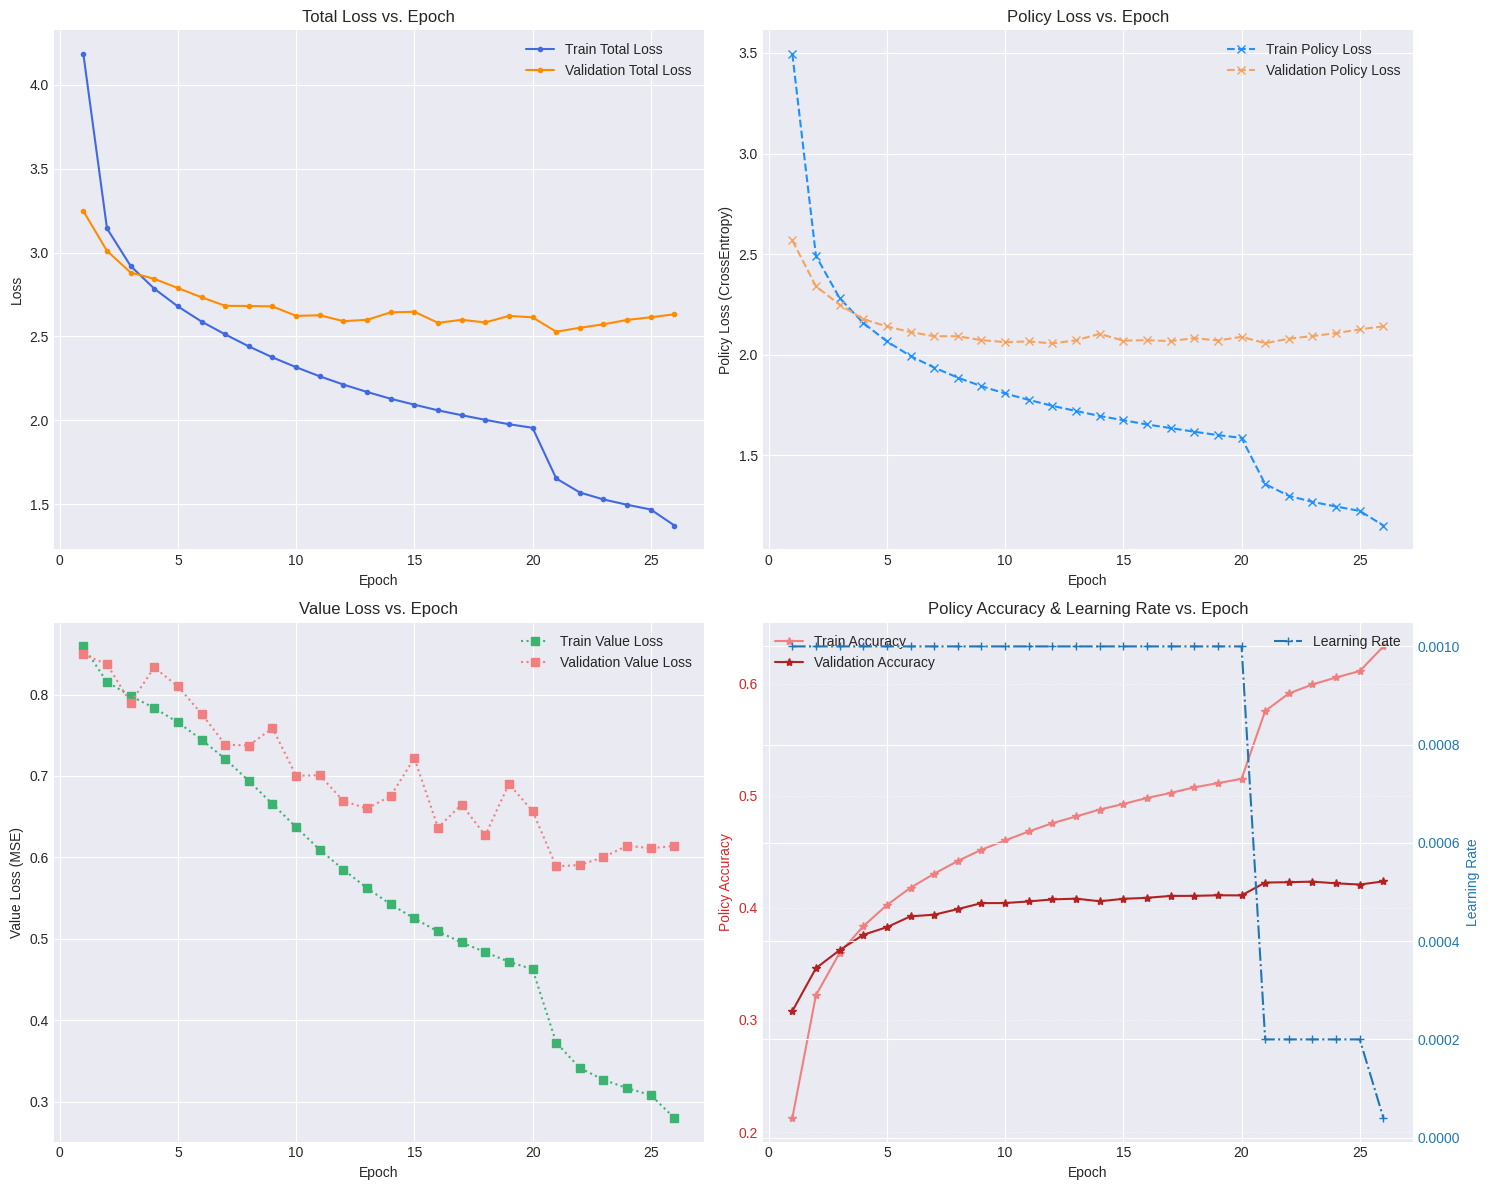

In [10]:
# Cell 11: Plot Training Graphs (Loss & Accuracy) (V5)

# %% {"cell_type": "code"}
if history['epoch']: # Check if training ran and history exists
    print("\n--- Plotting Training and Validation Progress ---")
    epochs_range = history['epoch']

    plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style
    plt.figure(figsize=(15, 12)) # Slightly larger figure

    # --- Plot Total Loss ---
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Total Loss', color='royalblue', marker='.')
    plt.plot(epochs_range, history['val_loss'], label='Validation Total Loss', color='darkorange', marker='.')
    plt.title('Total Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # --- Plot Policy Loss ---
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, history['train_policy_loss'], label='Train Policy Loss', color='dodgerblue', linestyle='--', marker='x')
    plt.plot(epochs_range, history['val_policy_loss'], label='Validation Policy Loss', color='sandybrown', linestyle='--', marker='x')
    plt.title('Policy Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Policy Loss (CrossEntropy)')
    plt.legend()

    # --- Plot Value Loss ---
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, history['train_value_loss'], label='Train Value Loss', color='mediumseagreen', linestyle=':', marker='s')
    plt.plot(epochs_range, history['val_value_loss'], label='Validation Value Loss', color='lightcoral', linestyle=':', marker='s')
    plt.title('Value Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Value Loss (MSE)')
    plt.legend()

    # --- Plot Policy Accuracy & Learning Rate --- ### V5 Change: Plot train & val accuracy
    ax1 = plt.subplot(2, 2, 4)
    color1 = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Policy Accuracy', color=color1)
    ax1.plot(epochs_range, history['train_policy_accuracy'], label='Train Accuracy', color='lightcoral', marker='*') # Train accuracy
    ax1.plot(epochs_range, history['val_policy_accuracy'], label='Validation Accuracy', color='firebrick', marker='*') # Validation accuracy
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.legend(loc='upper left') # Legend for accuracy

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color2 = 'tab:blue'
    ax2.set_ylabel('Learning Rate', color=color2)
    ax2.plot(epochs_range, history['lr'], label='Learning Rate', color=color2, linestyle='-.', marker='+')
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.legend(loc='upper right') # Legend for LR

    plt.title('Policy Accuracy & Learning Rate vs. Epoch')
    ax1.grid(True, axis='y', linestyle=':', alpha=0.6) # Add light grid for primary axis

    plt.tight_layout()
    plt.show()

else:
    print("\nNo training history found to plot.")

In [11]:
# Cell 12: Save Final Model and Mappings (V5)

# %% {"cell_type": "code"}
if 'model' in locals() and model is not None and 'move_to_int' in locals():
    # Save the final model state
    print(f"\nSaving final model state dict to: {MODEL_SAVE_PATH}")
    try:
        if isinstance(model, nn.DataParallel):
            state_dict_to_save = model.module.state_dict()
            print("  Saving final state_dict from model.module (DataParallel active)")
        else:
            state_dict_to_save = model.state_dict()
            print("  Saving final state_dict from model (DataParallel not active)")
        torch.save(state_dict_to_save, MODEL_SAVE_PATH)
        print("  Final model saved successfully.")
    except Exception as e:
        print(f"  Error saving final model: {e}")

    # Save mappings
    print(f"Saving mappings to: {MAPPING_SAVE_PATH}")
    try:
        mappings = {
            'move_to_int': loaded_move_to_int if 'loaded_move_to_int' in locals() and loaded_move_to_int else move_to_int,
            'int_to_move': loaded_int_to_move if 'loaded_int_to_move' in locals() and loaded_int_to_move else int_to_move,
            'num_classes': loaded_num_classes if 'loaded_num_classes' in locals() and loaded_num_classes else num_classes
        }
        with open(MAPPING_SAVE_PATH, "wb") as f:
            pickle.dump(mappings, f)
        print("  Mappings saved successfully!")
    except Exception as e:
        print(f"  Error saving mappings: {e}")

    print("\n--- Saving Complete ---")
    # Flag to indicate whether to use the best checkpoint during prediction
    LOAD_BEST_MODEL_FOR_PREDICTION = True if 'best_val_loss' in locals() and best_val_loss != float('inf') else False

else:
    print("\nSkipping final saving as model or mappings are not available.")
    LOAD_BEST_MODEL_FOR_PREDICTION = False


Saving final model state dict to: /kaggle/working/chess_model_v5_resnet_dropout.pth
  Saving final state_dict from model.module (DataParallel active)
  Final model saved successfully.
Saving mappings to: /kaggle/working/chess_mappings_v5.pkl
  Mappings saved successfully!

--- Saving Complete ---


In [12]:
# Cell 13: Prediction Setup (V5)

# %% {"cell_type": "code"}
# --- Load Mappings ---
loaded_mappings = None
loaded_move_to_int = None
loaded_int_to_move = None
loaded_num_classes = None
prediction_model = None
model_loaded_successfully = False

try:
    print(f"\n--- Prediction Setup ---")
    print(f"Loading mappings from: {MAPPING_SAVE_PATH}")
    with open(MAPPING_SAVE_PATH, "rb") as f:
        loaded_mappings = pickle.load(f)
    loaded_move_to_int = loaded_mappings['move_to_int']
    loaded_int_to_move = loaded_mappings['int_to_move']
    loaded_num_classes = loaded_mappings['num_classes']
    print("Mappings loaded successfully.")
    print(f"  Number of move classes: {loaded_num_classes}")
except Exception as e:
    print(f"Error: Could not load mapping file from {MAPPING_SAVE_PATH}: {e}")
    loaded_mappings = None

# --- Setup Device ---
if torch.cuda.is_available():
    prediction_device = torch.device("cuda")
    print(f"Using GPU for prediction.")
else:
    prediction_device = torch.device("cpu")
    print("Using CPU for prediction.")

# --- Load Model ---
model_path_to_load = MODEL_SAVE_PATH # Default to final model

# Choose whether to load the best model (if it was saved)
if LOAD_BEST_MODEL_FOR_PREDICTION:
     best_model_path = MODEL_SAVE_PATH.replace('.pth', '_best.pth')
     if os.path.exists(best_model_path):
         model_path_to_load = best_model_path
         print(f"Attempting to load BEST model from: {model_path_to_load}")
     else:
         print(f"Warning: Best model file '{best_model_path}' not found. Loading FINAL model instead: {model_path_to_load}")
else:
    print(f"Attempting to load FINAL model from: {model_path_to_load}")


if loaded_mappings and os.path.exists(model_path_to_load):
    print(f"\nLoading model structure and weights...")
    try:
        # Re-initialize model structure (V5) - ensure parameters match saved model!
        # Retrieve necessary parameters from the training setup cell (or save/load them)
        # Using globals from Cell 9 here for simplicity, but saving/loading config is safer
        prediction_model = ChessModelV5(
            num_policy_classes=loaded_num_classes,
            num_res_blocks=NUM_RES_BLOCKS,
            num_channels=NUM_CHANNELS,
            dropout_rate=DROPOUT_RATE # Pass dropout rate used during training
        )
        # Load the saved weights
        # Need to load onto CPU first if the model was saved from DataParallel
        state_dict = torch.load(model_path_to_load, map_location='cpu')
        # If it was saved directly from DataParallel, it might have 'module.' prefix
        # Create a new state dict without the prefix if necessary
        if all(key.startswith('module.') for key in state_dict.keys()):
             print("  Removing 'module.' prefix from state dict keys (saved from DataParallel).")
             from collections import OrderedDict
             new_state_dict = OrderedDict()
             for k, v in state_dict.items():
                 name = k[7:] # remove `module.`
                 new_state_dict[name] = v
             state_dict = new_state_dict

        prediction_model.load_state_dict(state_dict)
        prediction_model.to(prediction_device)
        prediction_model.eval() # Set to evaluation mode!
        print("Model loaded successfully and set to evaluation mode.")
        model_loaded_successfully = True
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path_to_load}.")
    except Exception as e:
        print(f"Error loading model state dict: {e}")
        print("Ensure the model definition (ResBlocks, Channels, Dropout etc.) in Cell 6 matches the saved model!")
        prediction_model = None
elif not loaded_mappings:
    print("\nSkipping model loading as mappings were not loaded.")
else:
    print(f"\nSkipping model loading as model file not found: {model_path_to_load}")


print("\n--- Prediction Setup Complete ---")


--- Prediction Setup ---
Loading mappings from: /kaggle/working/chess_mappings_v5.pkl
Mappings loaded successfully.
  Number of move classes: 1888
Using GPU for prediction.
Attempting to load BEST model from: /kaggle/working/chess_model_v5_resnet_dropout_best.pth

Loading model structure and weights...

ChessModelV5 initialized:
  Input Channels: 18
  Residual Blocks: 9 x 128 channels
  Dropout Rate: 0.3
  Policy Head Flattened Size: 2048
  Value Head Flattened Size: 1024
  Output Policy Classes: 1888
Initializing model weights...
Weight initialization complete.
Model loaded successfully and set to evaluation mode.

--- Prediction Setup Complete ---


<ipython-input-12-d84f7e68e36f>:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path_to_load, map_location='cpu')


In [13]:
# Cell 14: Prediction Function (V5)

# %% {"cell_type": "code"}
def prepare_input_v4(board: Board):
    """ Prepares a single board state for the V4/V5 model """ # Renaming not needed
    matrix = board_to_matrix_v4(board, flip=False)
    X_tensor = torch.tensor(matrix, dtype=torch.float32).unsqueeze(0) # Add batch dim [1, C, H, W]
    return X_tensor

def predict_move_v5(board: Board, model_to_use, device_to_use, int_to_move_map): # Renamed to V5
    """
    Predicts the best legal move using the V5 model.
    Returns: (best_legal_move_object, predicted_value)
    """
    if not model_loaded_successfully or not model_to_use or not int_to_move_map:
        print("Error: Model or mappings not ready in predict_move_v5.")
        return None, 0.0

    X_tensor = prepare_input_v4(board).to(device_to_use) # Use same prep function
    predicted_value = 0.0
    best_legal_move_obj = None
    best_prob = -1.0

    model_to_use.eval() # Ensure model is in eval mode
    with torch.no_grad():
        try:
            policy_logits, value_output = model_to_use(X_tensor)
            predicted_value = value_output.item()
            policy_logits = policy_logits.squeeze(0)
            probabilities = torch.softmax(policy_logits, dim=0).cpu().numpy()

            legal_moves = list(board.legal_moves)
            if not legal_moves: return None, predicted_value
            legal_moves_uci_set = {move.uci() for move in legal_moves}

            candidate_moves = {}
            for i, prob in enumerate(probabilities):
                 move_uci = int_to_move_map.get(i)
                 if move_uci in legal_moves_uci_set:
                     candidate_moves[move_uci] = prob

            if candidate_moves:
                 best_legal_move_uci = max(candidate_moves, key=candidate_moves.get)
                 best_prob = candidate_moves[best_legal_move_uci]
                 for move in legal_moves:
                      if move.uci() == best_legal_move_uci:
                           best_legal_move_obj = move
                           break
            else:
                 print("Warning: Model assigned zero probability to all legal moves! Picking random.")
                 best_legal_move_obj = random.choice(legal_moves)

        except Exception as e:
            print(f"Error during model prediction: {e}")
            legal_moves = list(board.legal_moves)
            if legal_moves:
                print("Picking random legal move due to prediction error.")
                best_legal_move_obj = random.choice(legal_moves)

    # Final checks
    if not best_legal_move_obj and board.is_game_over():
        return None, predicted_value
    elif not best_legal_move_obj:
        print("Critical Warning: No move selected, but game not over. Picking random.")
        legal_moves = list(board.legal_moves)
        if legal_moves: best_legal_move_obj = random.choice(legal_moves)

    return best_legal_move_obj, predicted_value

print("Prediction function predict_move_v5 defined.")

Prediction function predict_move_v5 defined.



--- Starting Prediction Example (V5) with SVG Output ---
Initial Board:


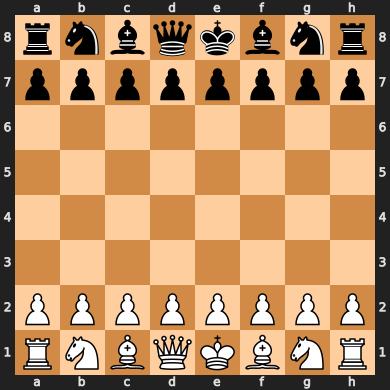


--- Move 1. White to Play ---
AI suggests move: e2e4 (Predicted Value: 0.039)

Board after 0.e2e4:


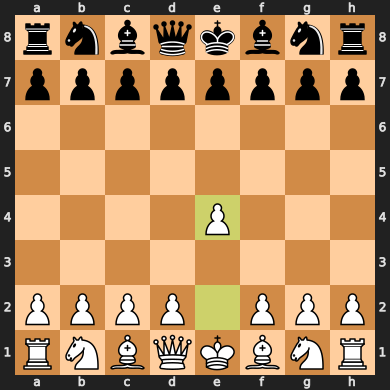


--- Move 1. ...Black to Play ---
AI suggests move: c7c5 (Predicted Value: 0.039)

Board after 2...c7c5:


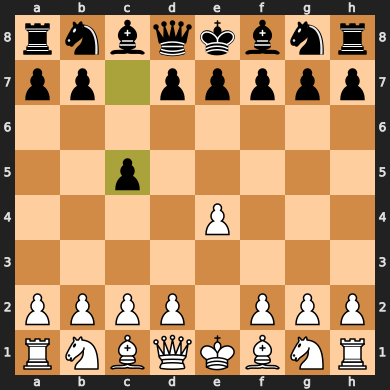


--- Move 2. White to Play ---
AI suggests move: g1f3 (Predicted Value: 0.039)

Board after 1.g1f3:


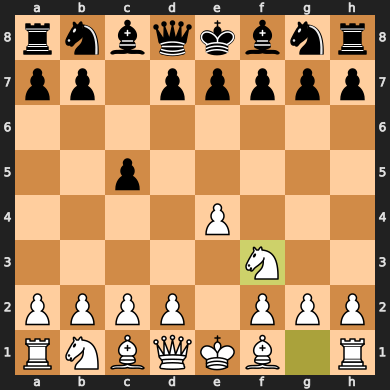


--- Move 2. ...Black to Play ---
AI suggests move: d7d6 (Predicted Value: 0.039)

Board after 3...d7d6:


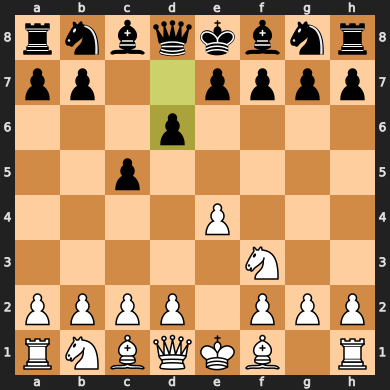


--- Move 3. White to Play ---
AI suggests move: d2d4 (Predicted Value: 0.039)

Board after 2.d2d4:


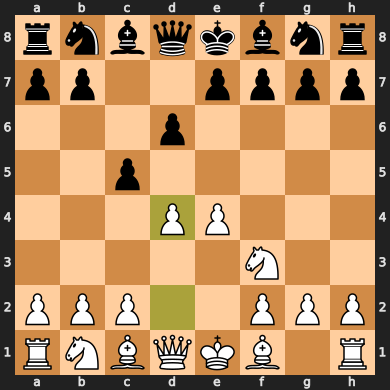


--- Move 3. ...Black to Play ---
AI suggests move: c5d4 (Predicted Value: 0.039)

Board after 4...c5d4:


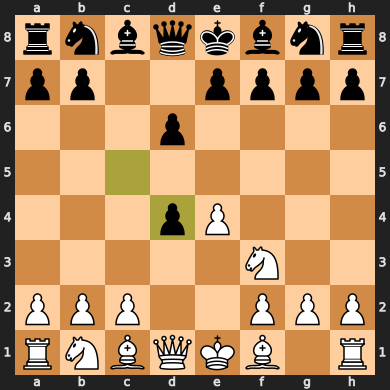


--- Move 4. White to Play ---
AI suggests move: f3d4 (Predicted Value: 0.039)

Board after 3.f3d4:


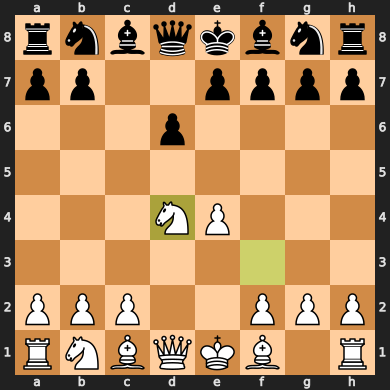


--- Move 4. ...Black to Play ---
AI suggests move: g8f6 (Predicted Value: 0.039)

Board after 5...g8f6:


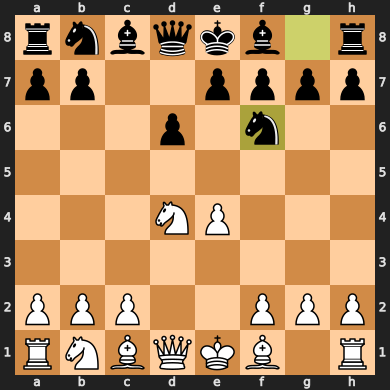


--- Move 5. White to Play ---
AI suggests move: b1c3 (Predicted Value: 0.072)

Board after 4.b1c3:


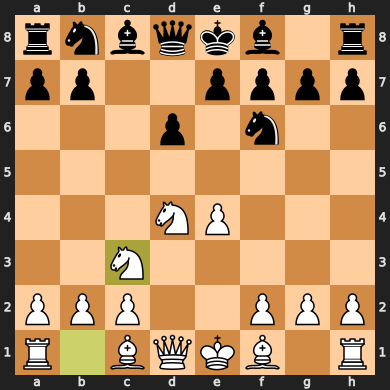


--- Move 5. ...Black to Play ---
AI suggests move: a7a6 (Predicted Value: 0.039)

Board after 6...a7a6:


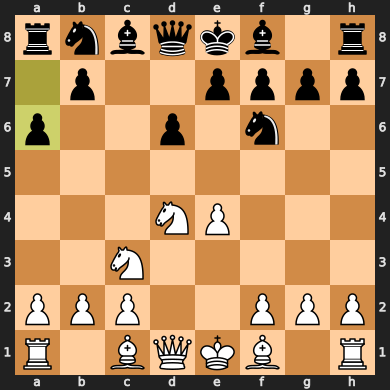


--- Move 6. White to Play ---
AI suggests move: c1g5 (Predicted Value: 0.039)

Board after 5.c1g5:


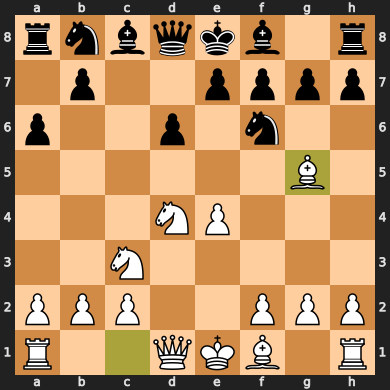


--- Move 6. ...Black to Play ---
AI suggests move: e7e6 (Predicted Value: 0.043)

Board after 7...e7e6:


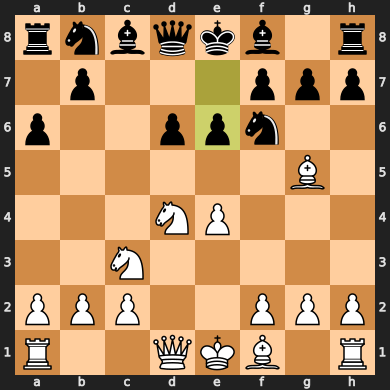


--- Move 7. White to Play ---
AI suggests move: f2f4 (Predicted Value: 0.039)

Board after 6.f2f4:


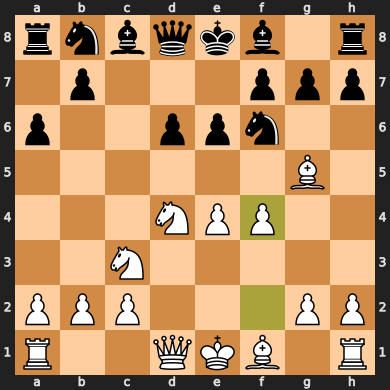


--- Move 7. ...Black to Play ---
AI suggests move: b8d7 (Predicted Value: 0.192)

Board after 8...b8d7:


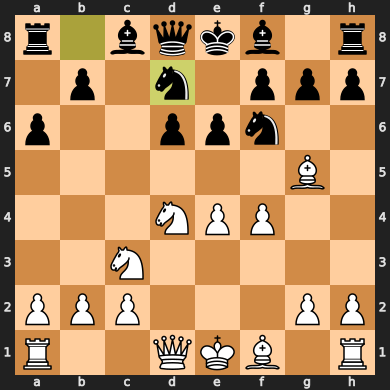


--- Move 8. White to Play ---
AI suggests move: d1f3 (Predicted Value: 0.017)

Board after 7.d1f3:


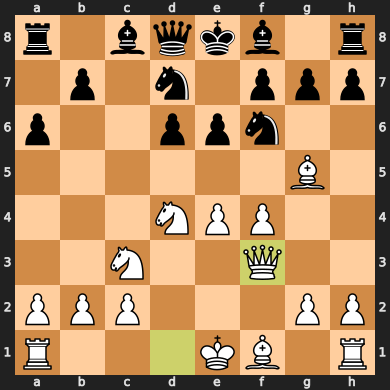


--- Move 8. ...Black to Play ---
AI suggests move: d8c7 (Predicted Value: 0.270)

Board after 9...d8c7:


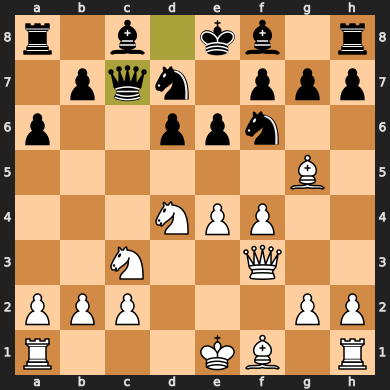


--- Move 9. White to Play ---
AI suggests move: e1c1 (Predicted Value: 0.086)

Board after 8.e1c1:


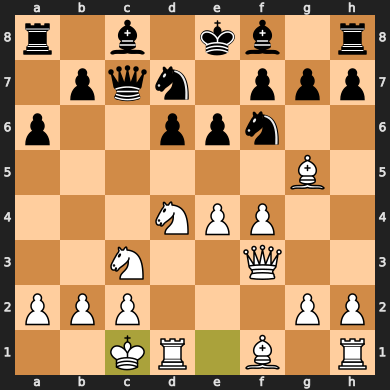


--- Move 9. ...Black to Play ---
AI suggests move: b7b5 (Predicted Value: 0.038)

Board after 10...b7b5:


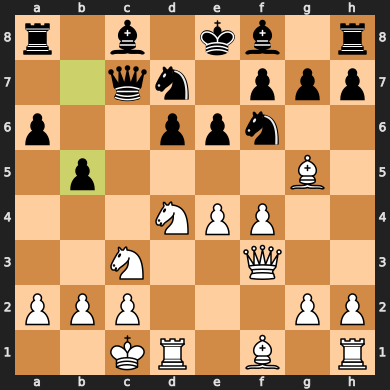


--- Move 10. White to Play ---
AI suggests move: f1d3 (Predicted Value: 0.589)

Board after 9.f1d3:


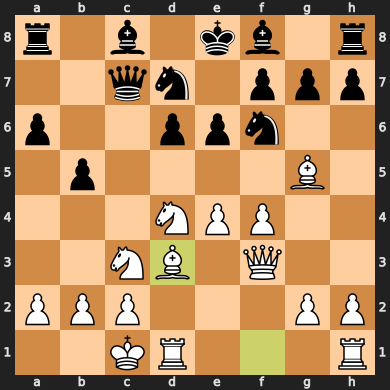


--- Move 10. ...Black to Play ---
AI suggests move: c8b7 (Predicted Value: 0.385)

Board after 11...c8b7:


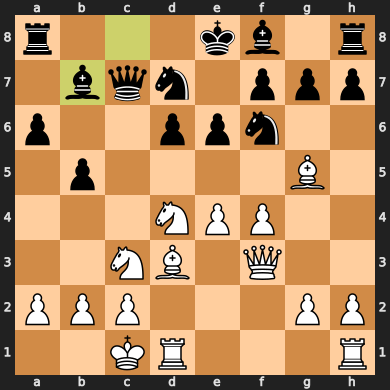


--- Move 11. White to Play ---
AI suggests move: h1e1 (Predicted Value: 0.664)

Board after 10.h1e1:


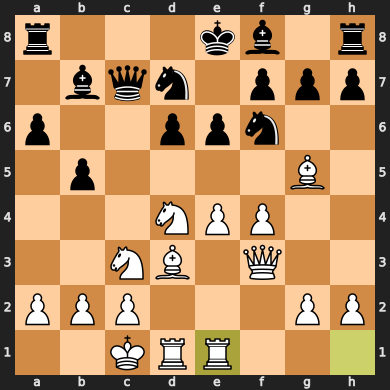


--- Move 11. ...Black to Play ---
AI suggests move: f8e7 (Predicted Value: 0.462)

Board after 12...f8e7:


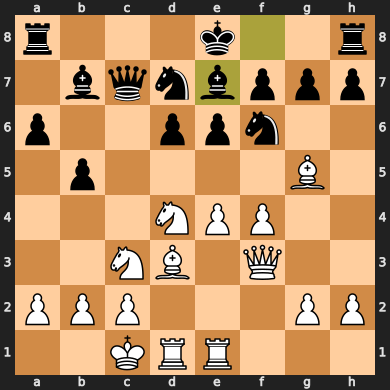


--- Move 12. White to Play ---
AI suggests move: f3g3 (Predicted Value: 0.676)

Board after 11.f3g3:


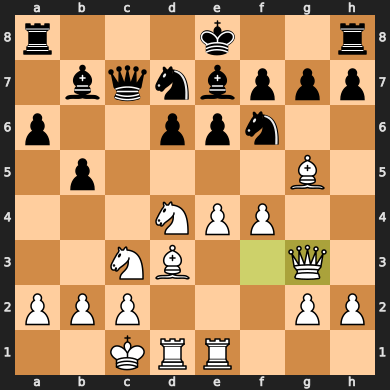


--- Move 12. ...Black to Play ---
AI suggests move: b5b4 (Predicted Value: -0.325)

Board after 13...b5b4:


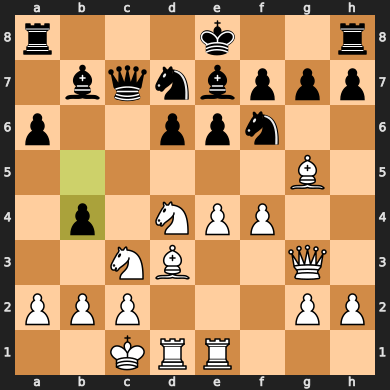


--- Move 13. White to Play ---
AI suggests move: c3e2 (Predicted Value: 0.561)

Board after 12.c3e2:


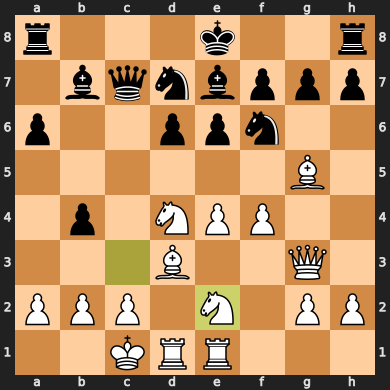


--- Move 13. ...Black to Play ---
AI suggests move: d7c5 (Predicted Value: -0.764)

Board after 14...d7c5:


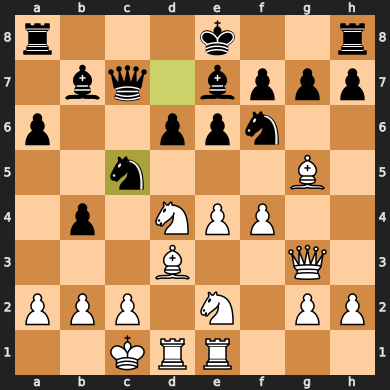


--- Move 14. White to Play ---
AI suggests move: f4f5 (Predicted Value: 0.124)

Board after 13.f4f5:


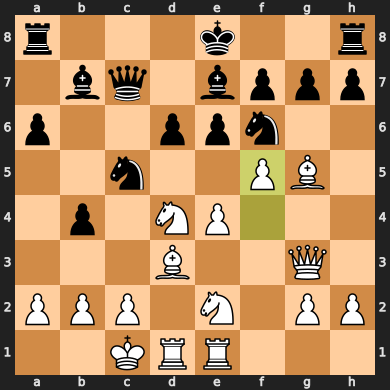


--- Move 14. ...Black to Play ---
AI suggests move: c5e4 (Predicted Value: -0.996)

Board after 15...c5e4:


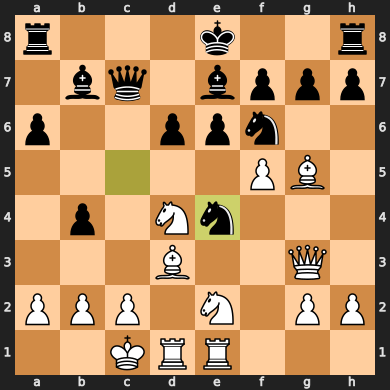


--- Move 15. White to Play ---
AI suggests move: g3h4 (Predicted Value: -0.985)

Board after 14.g3h4:


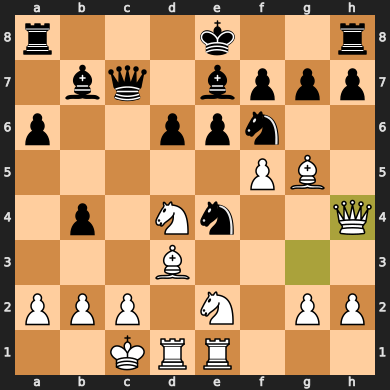


--- Move 15. ...Black to Play ---
AI suggests move: e6e5 (Predicted Value: -0.991)

Board after 16...e6e5:


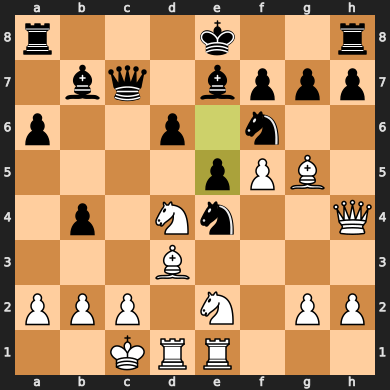


--- Move 16. White to Play ---
AI suggests move: d3e4 (Predicted Value: -0.979)

Board after 15.d3e4:


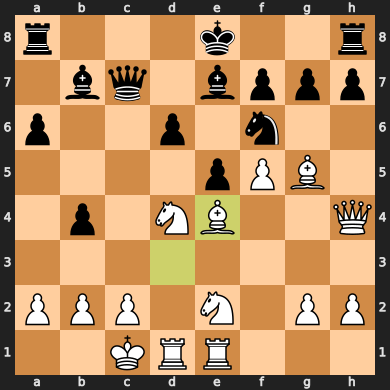


--- Move 16. ...Black to Play ---
AI suggests move: b7e4 (Predicted Value: -0.910)

Board after 17...b7e4:


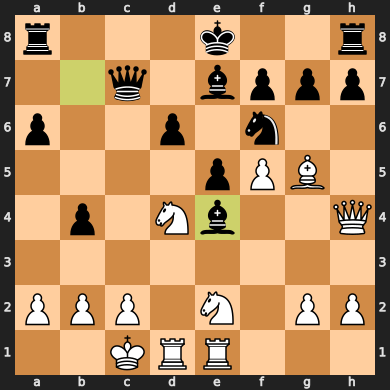


--- Move 17. White to Play ---
AI suggests move: e2g3 (Predicted Value: 0.508)

Board after 16.e2g3:


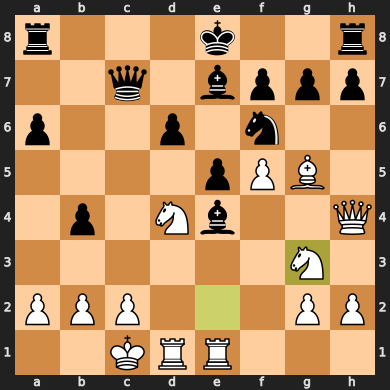


--- Move 17. ...Black to Play ---
AI suggests move: e4d5 (Predicted Value: -0.879)

Board after 18...e4d5:


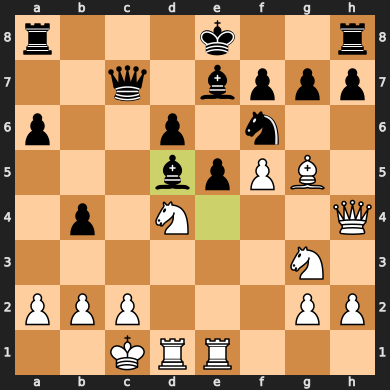


--- Move 18. White to Play ---
AI suggests move: g5f6 (Predicted Value: -0.712)

Board after 17.g5f6:


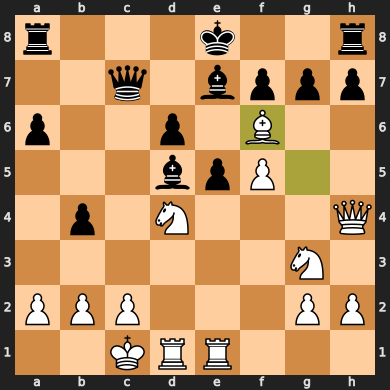


--- Move 18. ...Black to Play ---
AI suggests move: e7f6 (Predicted Value: -0.998)

Board after 19...e7f6:


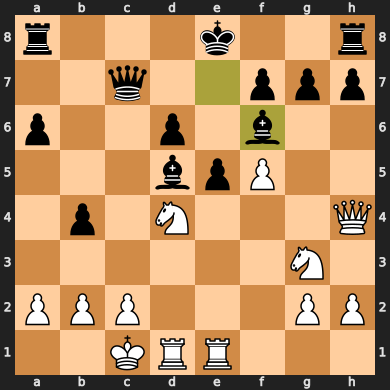


--- Move 19. White to Play ---
AI suggests move: h4h3 (Predicted Value: -0.284)

Board after 18.h4h3:


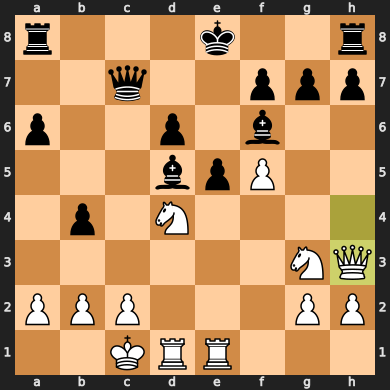


--- Move 19. ...Black to Play ---
AI suggests move: e8g8 (Predicted Value: -0.999)

Board after 20...e8g8:


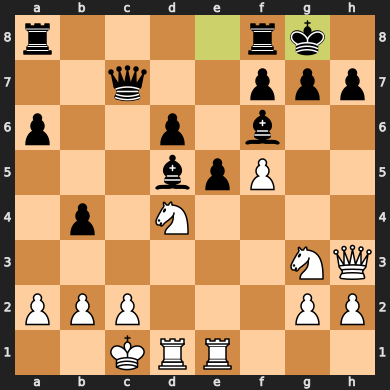


--- Move 20. White to Play ---
AI suggests move: g3h5 (Predicted Value: -0.990)

Board after 19.g3h5:


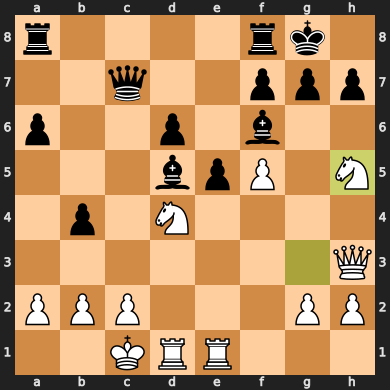


--- Move 20. ...Black to Play ---
AI suggests move: a8c8 (Predicted Value: -0.993)

Board after 21...a8c8:


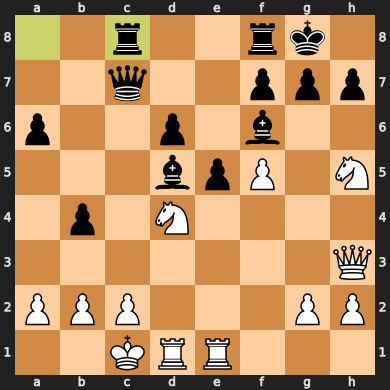


--- Move 21. White to Play ---
AI suggests move: d4e2 (Predicted Value: -0.984)

Board after 20.d4e2:


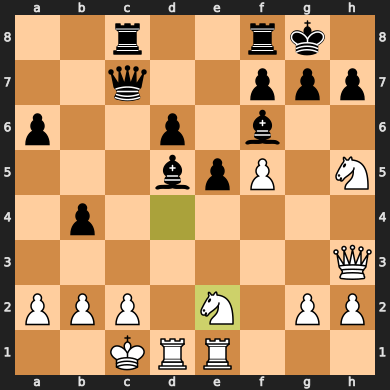


--- Move 21. ...Black to Play ---
AI suggests move: f6g5 (Predicted Value: -0.973)

Board after 22...f6g5:


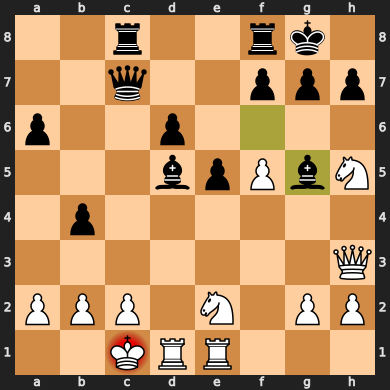


--- Move 22. White to Play ---
AI suggests move: c1b1 (Predicted Value: -0.976)

Board after 21.c1b1:


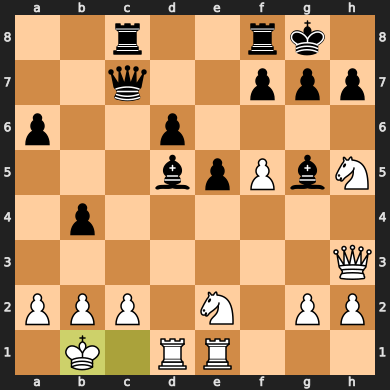


--- Move 22. ...Black to Play ---
AI suggests move: c7c2 (Predicted Value: -0.989)

Board after 23...c7c2:


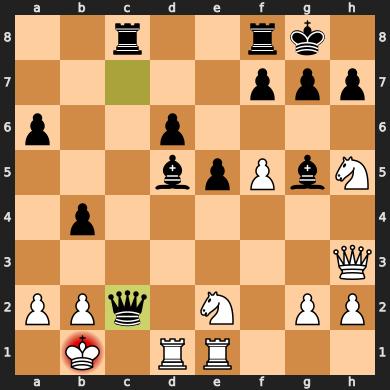


--- Move 23. White to Play ---
AI suggests move: b1a1 (Predicted Value: -0.921)

Board after 22.b1a1:


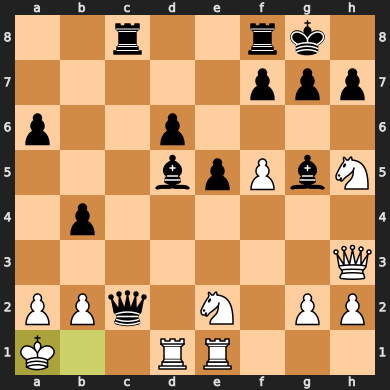


--- Move 23. ...Black to Play ---
AI suggests move: d5g2 (Predicted Value: -0.998)

Board after 24...d5g2:


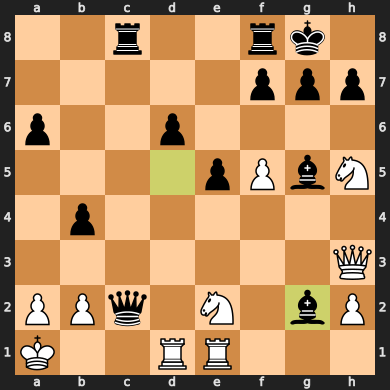


--- Move 24. White to Play ---
AI suggests move: e1g1 (Predicted Value: -0.967)

Board after 23.e1g1:


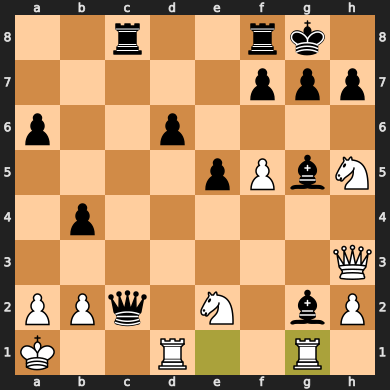


--- Move 24. ...Black to Play ---
AI suggests move: g2h3 (Predicted Value: -0.995)

Board after 25...g2h3:


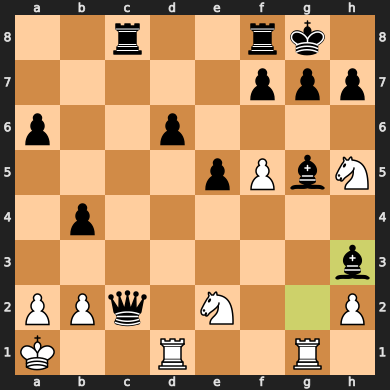


--- Move 25. White to Play ---
AI suggests move: h5g7 (Predicted Value: -0.995)

Board after 24.h5g7:


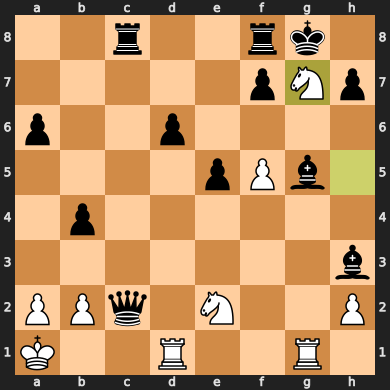


--- Move 25. ...Black to Play ---
AI suggests move: c2e2 (Predicted Value: -1.000)

Board after 26...c2e2:


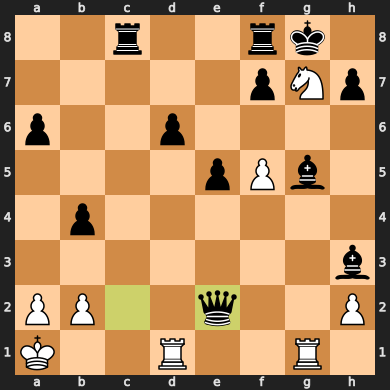


--- Prediction Example Finished ---

Final Board State:


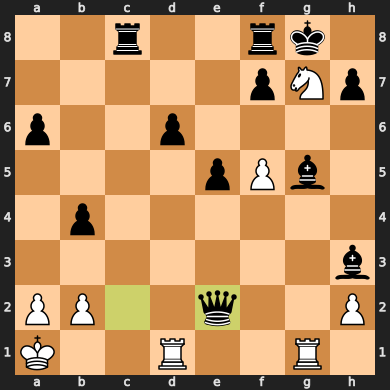

In [14]:
# Cell 15: Example Prediction with SVG Output (V5)

# %% {"cell_type": "code"}
if model_loaded_successfully:
    board = Board()
    print("\n--- Starting Prediction Example (V5) with SVG Output ---")
    MAX_PREDICTION_MOVES = 50 # Play N moves
    move_counter = 0

    try:
        print("Initial Board:")
        display(SVG(board._repr_svg_()))

        while move_counter < MAX_PREDICTION_MOVES:
            move_counter += 1
            current_player = "White" if board.turn else "Black"
            print(f"\n--- Move {board.fullmove_number}. {'...' if not board.turn else ''}{current_player} to Play ---")

            if board.is_game_over(claim_draw=True):
                print(f"Game Over! Result: {board.result(claim_draw=True)}")
                break

            ai_move, predicted_val = predict_move_v5(board, prediction_model, prediction_device, loaded_int_to_move) ### V5 Change: Call V5 function

            if ai_move:
                move_uci = ai_move.uci()
                print(f"AI suggests move: {move_uci} (Predicted Value: {predicted_val:.3f})")
                board.push(ai_move)
                print(f"\nBoard after {board.fullmove_number-1 if not board.turn else board.fullmove_number}.{'..' if board.turn else ''}{move_uci}:")
                display(SVG(board._repr_svg_()))
            else:
                print(f"AI could not suggest a valid move for {current_player}.")
                if board.is_game_over(claim_draw=True):
                     print(f"Game Over! Result: {board.result(claim_draw=True)}")
                break

    except Exception as e:
         print(f"\nAn unexpected error occurred during the prediction simulation: {e}")
         import traceback
         traceback.print_exc()

    print("\n--- Prediction Example Finished ---")
    print("\nFinal Board State:")
    display(SVG(board._repr_svg_()))
    if board.is_game_over(claim_draw=True):
         print(f"Final Result: {board.result(claim_draw=True)}")

else:
    print("\nPrediction model or mappings not loaded/ready. Skipping prediction example.")


# %% [markdown]
# ---
# Excellent! This V5 notebook incorporates **Dropout** and **Early Stopping** to combat overfitting, sets **Data Augmentation** as the default, and includes **Training Accuracy** in the plots.
#
# **Important Reminders:**
# *   **Data Augmentation:** If you load preprocessed data created with V4 (where augmentation might have been off), you **must** set `LOAD_PREPROCESSED_DATA = False` in Cell 7 and re-run it *at least once* with `USE_AUGMENTATION = True` to benefit from the augmentation during training.
# *   **Hyperparameters:** Remember to adjust settings in Cells 7 and 9 (paths, ELO, sample limits, batch size, model layers, epochs, dropout rate, weight decay, patience values) for your specific needs and resources.
# *   **Tuning:** Finding the *optimal* dropout rate, weight decay, and model complexity often requires experimentation. This version provides a good starting point with regularization.
#
# Let me know if you run into any issues or want further refinements! Good luck with training V5! 😊